# MSDS 610 Final Project Part I - Oussama Ennaciri
## Part I : Picking a Scenario
The purpose of this project is to build an MLS data pipeline. I will be simulating a scenario in the real estate sector by analyzing a dataset of Airbnb listings in Chicago, IL. My goal is to build a model that determines the optimal nightly rental price based on the type of dwelling purchased.

## Part II : Loading, Spliting, and Storing the Data
In this section, I will randomly select 100 rows from my dataset and save them to a new CSV file. These rows will be removed from the primary dataset and will serve as "live data" for later stages of the analysis, allowing me to test and validate the model on unseen data. The remaining dataset will be stored in the raw schema of my local PostgreSQL database to ensure data integrity and accessibility for processing and model training.

In [1840]:
import kagglehub
import seaborn as sns
import pandas as pd
from sqlalchemy import create_engine
from IPython.display import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datetime import datetime
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import joblib
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


In [1841]:
path = kagglehub.dataset_download("jinbonnie/chicago-airbnb-open-data")
print("Path to dataset files:", path)

Path to dataset files: /Users/oussamaennaciri/.cache/kagglehub/datasets/jinbonnie/chicago-airbnb-open-data/versions/2


In [1842]:
file_name = "listings.csv"
listings = pd.read_csv(os.path.join(path, file_name))
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168


In [1843]:
listings.shape

(6397, 16)

In [1844]:
listings_live = listings.sample(n=100, random_state=42)
listings_live.to_csv("listings_live.csv", index=False)
listings = listings.drop(listings_live.index)
listings.shape

(6297, 16)

In [1845]:
host = r'127.0.0.1'
db = r'MSDS610 - Final Project'
user = r'postgres'
pw = r'password'
port = r'5432'
schema = r'raw' 

In [1846]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [1847]:
table_name = r'listings_raw'
schema = r'raw'

listings.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

6297

In [1848]:
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,listings_raw


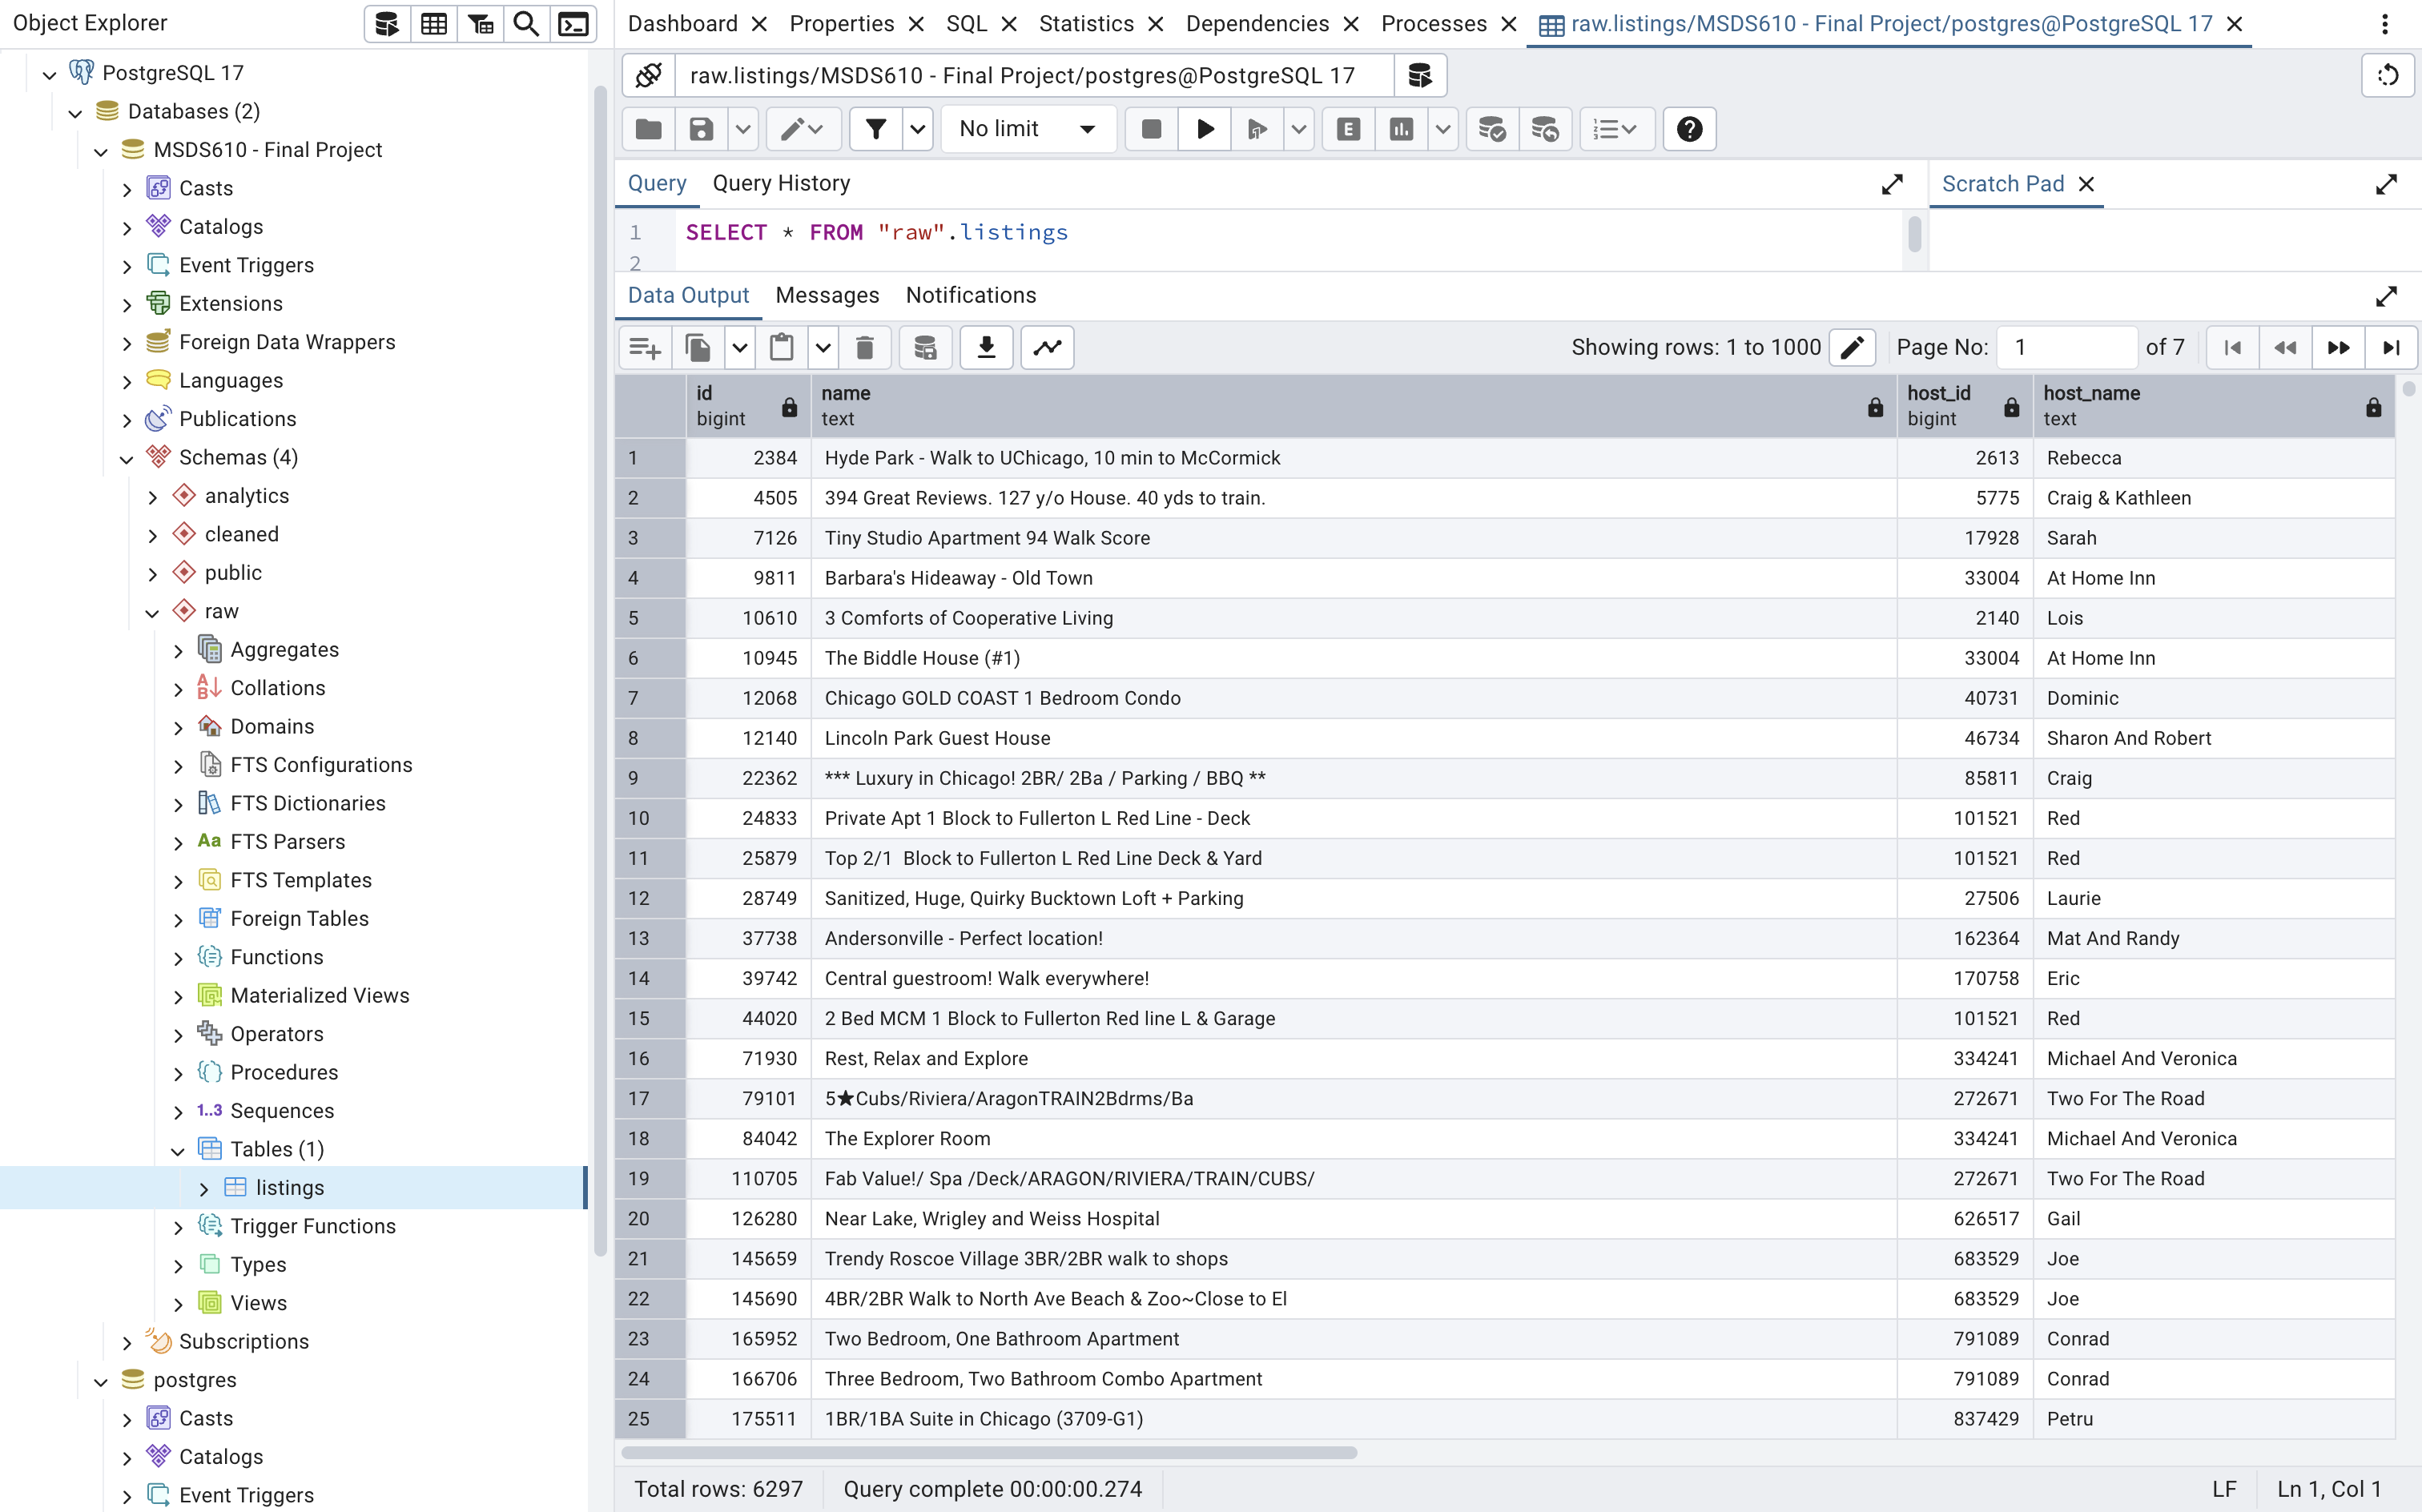

In [1849]:
Image("newly created table.png")

## Part III

The dataset I will be analyzing consists of information about rental properties in Chicago. Key features include property information, host information, and booking conditions.
The goal of the analysis is to answer the question: "How much should we charge per night for a rental property in Chicago based on the type of dwelling?" The target variable for this analysis is price, which represents the nightly rental cost. By examining the relationship between relevant features and price, I will be able to build a model that determins optimal pricing for different types of rental properties in Chicago.

|Field Name|Description|Data_Type|
|---|---|---|
|id|Unique identifier to differentiate listings|Nominal|
|name|Title of the listing|Nominal|
|host_id|Unique identifier to differentiate the hosts|Nominal|
|host_name|Name of the host|Nominal|
|neighbourhood_group|Group that each neighborhood belongs to|Nominal|
|neighbourhood|Neighbourhood where the rental is located|Nominal|
|latitude|Horizontal geographic coordinate|Continuous|
|longitude|Vertical geographic coordinate|Continuous|
|room_type|Type of room being rented (entire home/room)|Nominal|
|price|Nightly cost for each listing|Continuous|
|minimum_nights|Minimum nights required to be able to book the property|Discrete|
|number_of_reviews|Total number ofreviews received for each listing|Discrete|
|last_review|Date of the most recent review|Ordinal|
|reviews_per_month|Average number of monthly reviews|Continuous|
|calculated_host_listings_count|Total number of properties each host has listed|Discrete|
|availability_365|Availability of the listing|Discrete|

## Part IV : Data Preparation and Feature Selection
This dataset consists of 6,297 entries and 16 columns none of which are duplicated, with features about rental properties in Chicago. Potential issues include completely missing data in the neighbourhood_group column and partial missing data in last_review and reviews_per_month. Additional issues invole columns like last_review that would require transformation to a date_type type and room_type which would require encoding in order to proceed with the analysis.

In [1850]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6297 entries, 0 to 6396
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6297 non-null   int64  
 1   name                            6297 non-null   object 
 2   host_id                         6297 non-null   int64  
 3   host_name                       6297 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   6297 non-null   object 
 6   latitude                        6297 non-null   float64
 7   longitude                       6297 non-null   float64
 8   room_type                       6297 non-null   object 
 9   price                           6297 non-null   int64  
 10  minimum_nights                  6297 non-null   int64  
 11  number_of_reviews               6297 non-null   int64  
 12  last_review                     5183 no

In [1851]:
listings[listings.duplicated()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


I removed the columns id, name, host_id, host_name from my dataframe to aliminate non-essential information that doesn't affect the target and therefore doesn't contribute to the analysis. I also eliminated the column neighbourhood_group due to it containing no data. This will help streamline the dataset by reducing noise, and therefore improving model efficiency.

In [1852]:
listings = listings.drop(columns=['id', 'name', 'host_id', 'host_name','neighbourhood_group'])

I carefully handled the missing data in the last_review column, as it contained a significant number of null values. Deleting the corresponding rows could have led to data loss, and therefore a potential incomplete analysis. Instead, I opted to fill the missing values with the earliest date, preserving the dataset's integrity while ensuring that no valuable information was lost.

In [1853]:
listings['last_review'] = pd.to_datetime(listings['last_review'], errors='coerce')
earliest_date = listings['last_review'].dropna().min()
listings['last_review'].fillna(earliest_date, inplace=True)
earliest_date

Timestamp('2013-08-18 00:00:00')

I filled missing values in the reviews_per_month column with 0, because a missing value likely indicates that the listing has never received a review.

In [1854]:
listings['reviews_per_month'].fillna(0.0, inplace=True)

I applied mean encoding to the neighbourhood and room_type columns by replacing each category with the average price of listings for each category. This transformation converts categorical data into a meaningful numerical format while preserving important pricing patterns. I chose this approach to be able to generate a correlation map later. After encoding, I dropped the original categorical columns since they were no longer needed.

In [1855]:
listings['neighbourhood_encoded'] = listings.groupby('neighbourhood')['price'].transform('mean')
listings['room_type_encoded'] = listings.groupby('room_type')['price'].transform('mean')
listings=listings.drop(columns=['neighbourhood', 'room_type'])

I created a correlation matrix to visualize the relationships between my features and the target, and see how each feature influences pricing. 

In [1856]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6297 entries, 0 to 6396
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   latitude                        6297 non-null   float64       
 1   longitude                       6297 non-null   float64       
 2   price                           6297 non-null   int64         
 3   minimum_nights                  6297 non-null   int64         
 4   number_of_reviews               6297 non-null   int64         
 5   last_review                     6297 non-null   datetime64[ns]
 6   reviews_per_month               6297 non-null   float64       
 7   calculated_host_listings_count  6297 non-null   int64         
 8   availability_365                6297 non-null   int64         
 9   neighbourhood_encoded           6297 non-null   float64       
 10  room_type_encoded               6297 non-null   float64       
dtypes: dateti

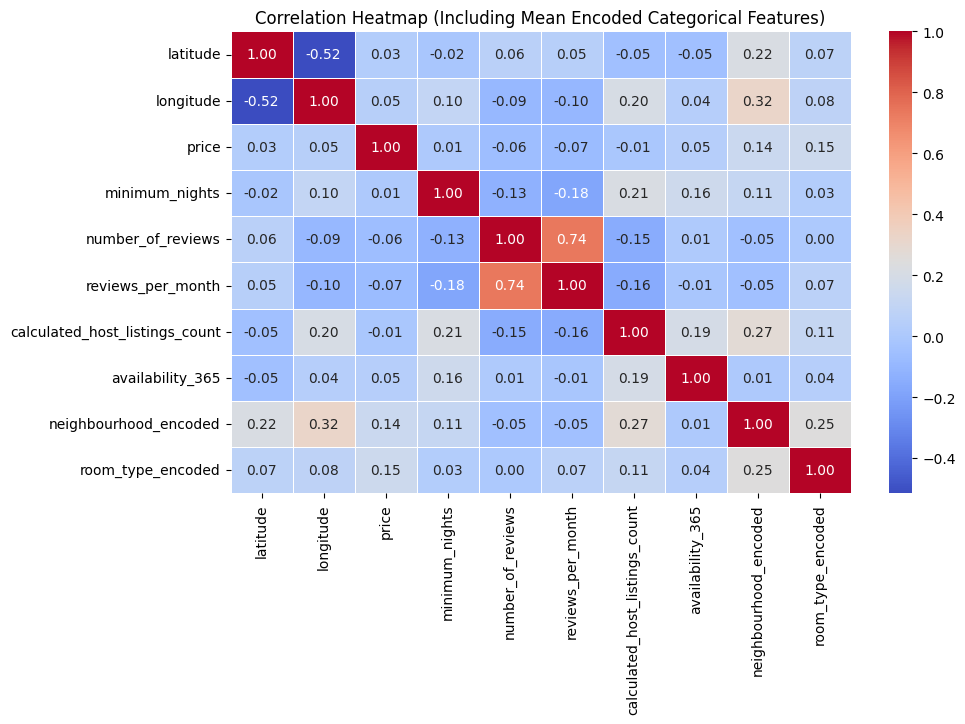

In [1857]:
numeric_columns = listings.select_dtypes(include=['number']).columns
corr_matrix = listings[numeric_columns].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Including Mean Encoded Categorical Features)")
plt.show()

I dropped the minimum_nights and calculated_host_listings_count columns because they showed relatively weak correlation with the target variable, price, compared to other features. 

In [1858]:
listings = listings.drop(columns=['minimum_nights','calculated_host_listings_count'])

In [1859]:
transformation_log = pd.DataFrame({
    "field_name": [
        "id", "name", "host_id", "host_name", "neighbourhood_group",
        "last_review", "reviews_per_month", "neighbourhood_encoded", "room_type_encoded",
        "minimum_nights", "calculated_host_listings_count"
    ],
    "manipulation_type": [
        "Drop Column", "Drop Column", "Drop Column", "Drop Column", "Drop Column",
        "Fill Missing with earliest date & Convert to Datetime", "Fill Missing", 
        "Mean Encoding & Drop Column", "Mean Encoding & Drop Column",
        "Drop Column", "Drop Column"
    ],
    "value": [
        "Not Relevant for Pricing", "Not Relevant for Pricing", 
        "Not Relevant for Pricing", "Not Relevant for Pricing", "No Data",
        "2013-08-18", "0.0", 
        "Average Price per Neighbourhood", "Average Price per Room Type", 
        "Weak Correlation", "Weak Correlation"
    ]
})

transformation_log

,field_name,manipulation_type,value
0,id,Drop Column,Not Relevant for Pricing
1,name,Drop Column,Not Relevant for Pricing
2,host_id,Drop Column,Not Relevant for Pricing
3,host_name,Drop Column,Not Relevant for Pricing
4,neighbourhood_group,Drop Column,No Data
5,last_review,Fill Missing with earliest date & Convert to D...,2013-08-18
6,reviews_per_month,Fill Missing,0.0
7,neighbourhood_encoded,Mean Encoding & Drop Column,Average Price per Neighbourhood
8,room_type_encoded,Mean Encoding & Drop Column,Average Price per Room Type
9,minimum_nights,Drop Column,Weak Correlation


In [1860]:
host = r'127.0.0.1'
db = r'MSDS610 - Final Project'
user = r'postgres'
pw = r'password'
port = r'5432'
schema = r'cleaned' 

In [1861]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [1862]:
table_name = r'listings_cleaned'
schema = r'cleaned'

listings.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

6297

In [1863]:
table_name = r'transformation_log'
schema = r'cleaned'

transformation_log.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

11

In [1864]:
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,listings_cleaned
1,new_features_log
2,transformation_log


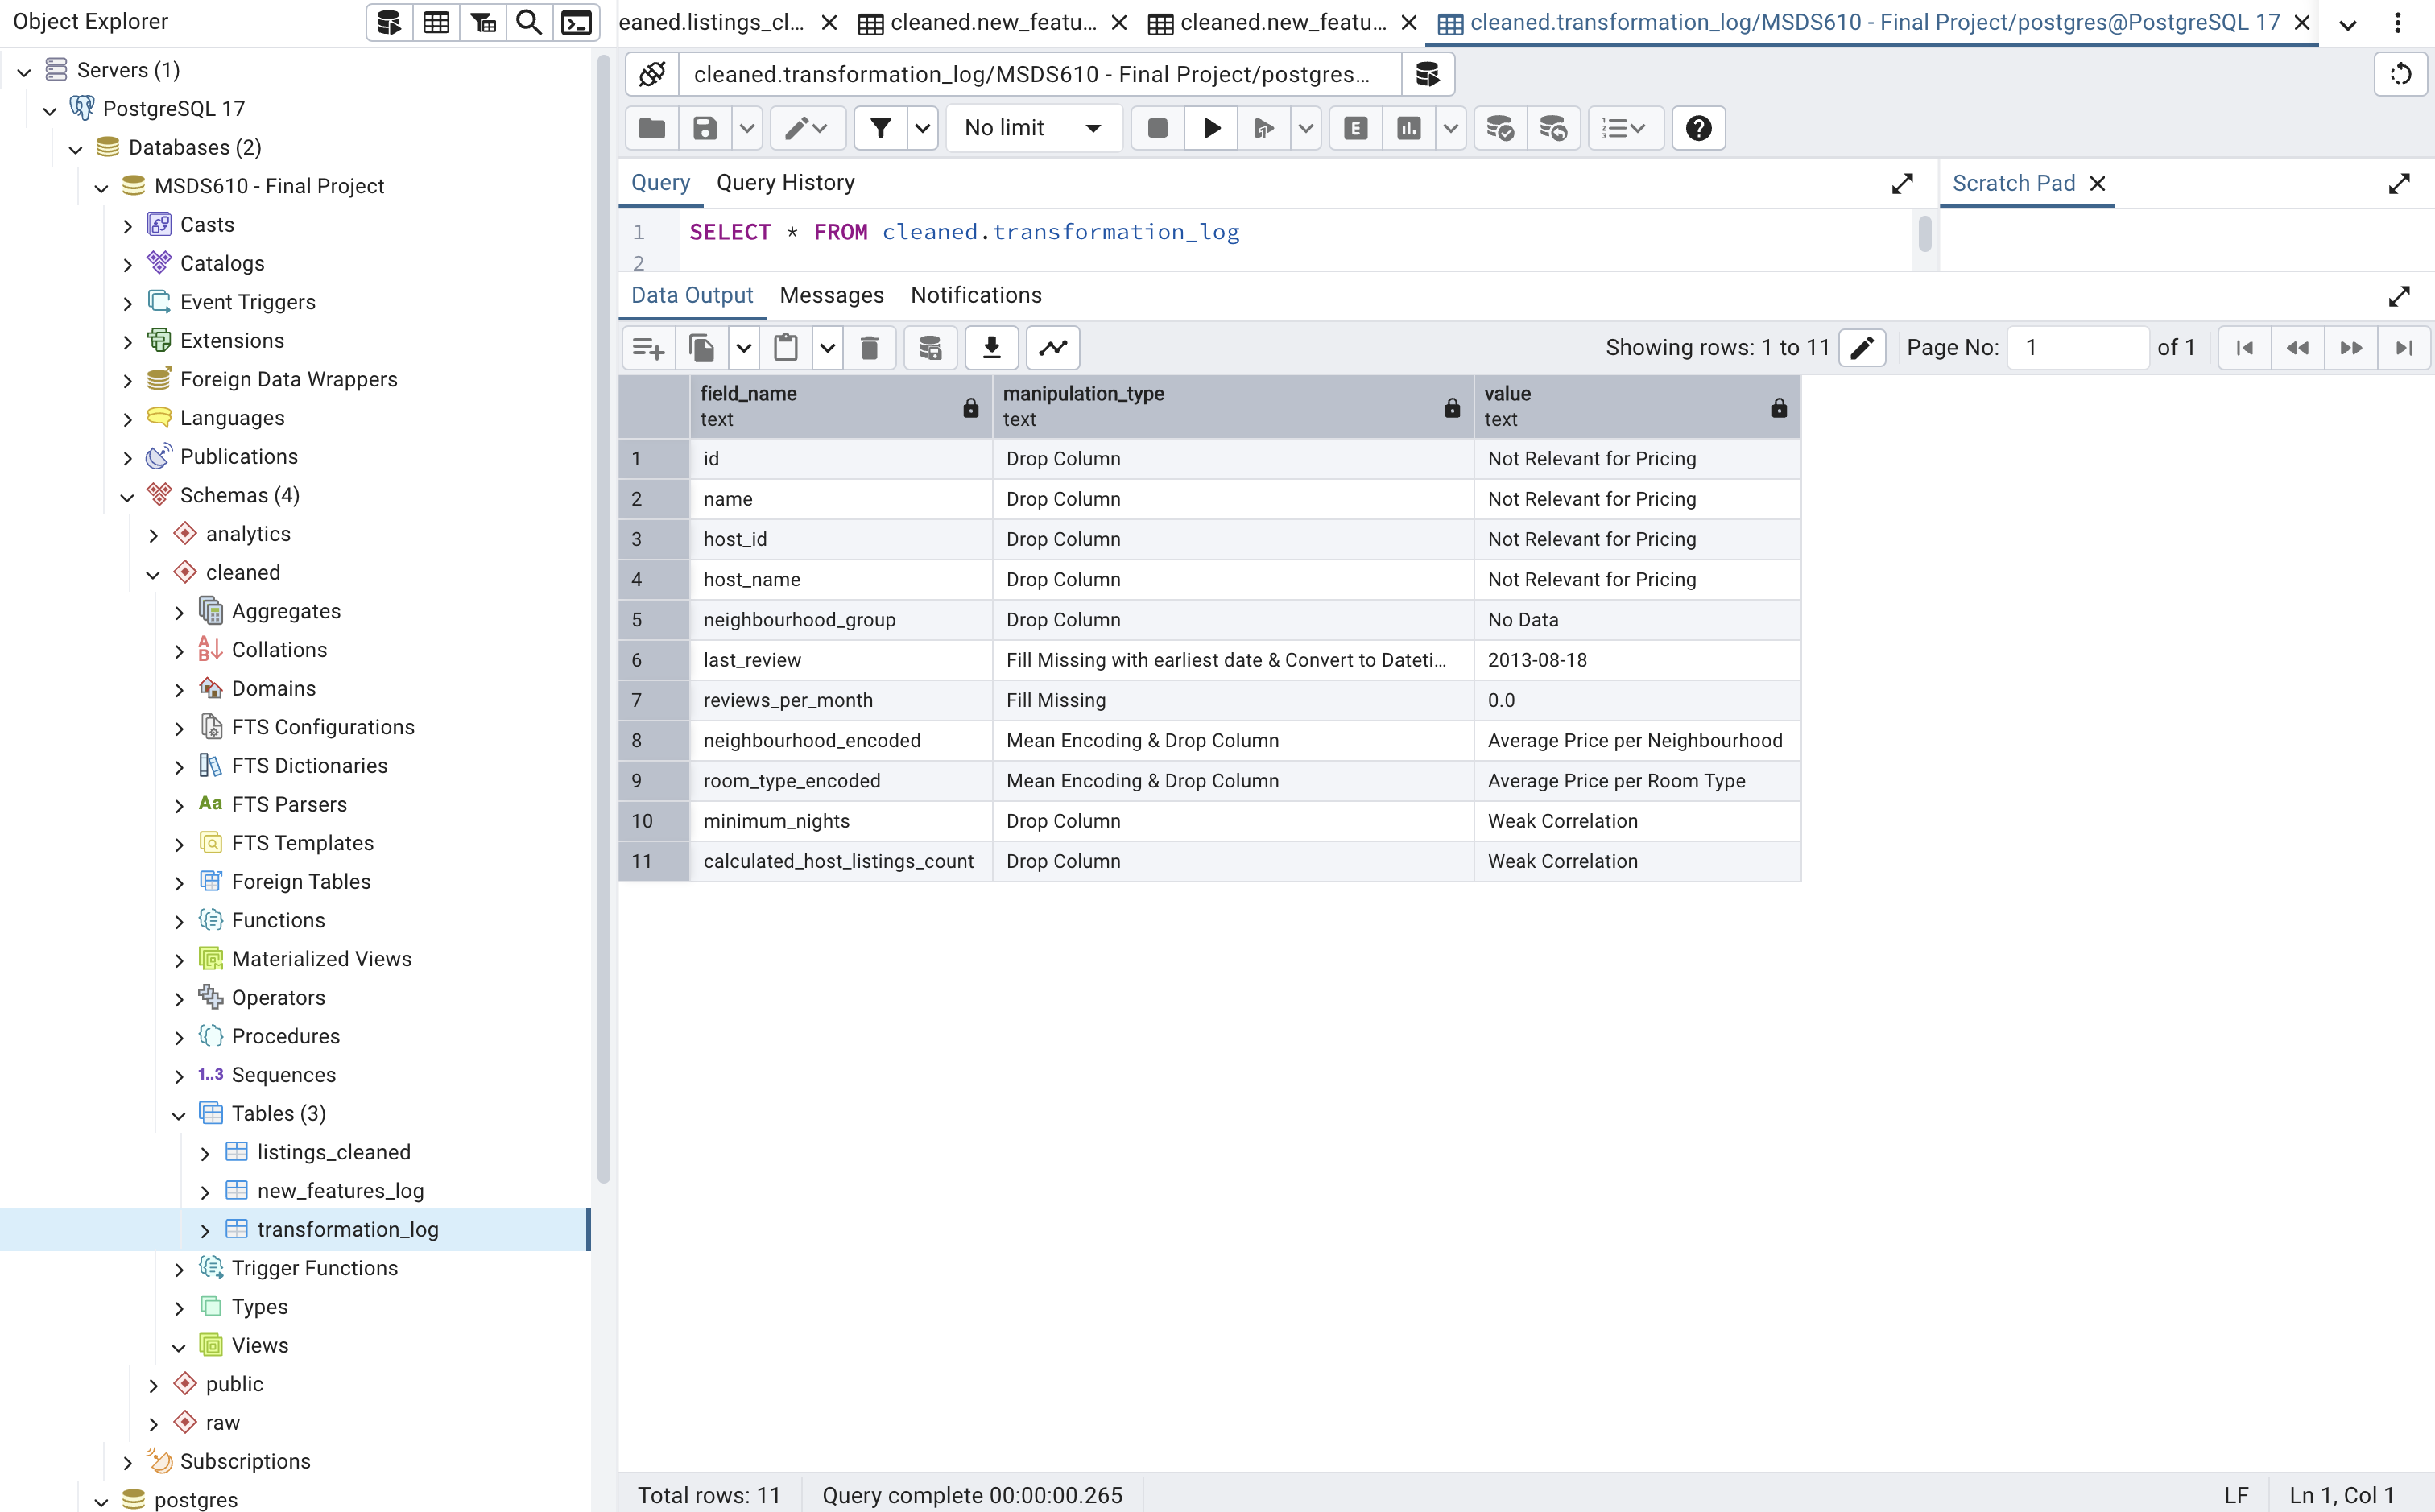

In [1880]:
Image("transformation_log.png")

I engineered two new features to enhance the dataset. Days Since Last Review measures the number of days since a listing’s last review, providing insight into its activity and relevance. Distance to Center calculates how far each listing is from Center Chicago, capturing the impact of location on price. After extracting these features, I removed the original last_review, latitude, and longitude columns to streamline the data.

In [1866]:
listings['last_review'] = pd.to_datetime(listings['last_review'], errors='coerce')
listings['days_since_last_review'] = (datetime.today() - listings['last_review']).dt.days
listings = listings.drop(columns=['last_review'])

In [1867]:
listings["distance_to_center"] = listings.apply(
    lambda row: geodesic((row["latitude"], row["longitude"]), (41.881832, -87.623177)).miles, 
    axis=1
)
listings = listings.drop(columns=['latitude','longitude'])


I identified and removed outliers for price, neighbourhood_encoded, and room_type_encoded. This helped eliminate extreme values that could skew the model. 

In [1869]:
print(f"Original shape: {listings.shape}")
column = 'price' 
Q1 = listings[column].quantile(0.25)
Q3 = listings[column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
listings = listings[(listings[column] >= lower_bound) & (listings[column] <= upper_bound)]
print(f"Cleaned shape: {listings.shape}")

Original shape: (6297, 8)
Cleaned shape: (5748, 8)


In [1870]:
print(f"Original shape: {listings.shape}")
column = 'neighbourhood_encoded'  
Q1 = listings[column].quantile(0.25)
Q3 = listings[column].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
listings = listings[(listings[column] >= lower_bound) & (listings[column] <= upper_bound)]
print(f"Cleaned shape: {listings.shape}")

Original shape: (5748, 8)
Cleaned shape: (5746, 8)


In [1871]:
print(f"Original shape: {listings.shape}")
column = 'room_type_encoded'  
Q1 = listings[column].quantile(0.25)
Q3 = listings[column].quantile(0.75)
IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
listings = listings[(listings[column] >= lower_bound) & (listings[column] <= upper_bound)]
print(f"Cleaned shape: {listings.shape}")

Original shape: (5746, 8)
Cleaned shape: (5678, 8)


In [1872]:
listings = listings.drop(columns=['days_since_last_review', 'number_of_reviews'])

In [1873]:
new_features_log = pd.DataFrame({
    "field_name": [
        "last_review", "days_since_last_review", "latitude", "longitude", "distance_to_center",
        "price, neighbourhood_encoded, room_type_encoded", "days_since_last_review", "number_of_reviews"
    ],
    "manipulation_type": [
        "Convert to Datetime & Drop Column", 
        "Calculate Days Since Last Review", 
        "Drop Column", 
        "Drop Column", 
        "Calculate Distance to Downtown & Add Column",
        "Remove Outliers using IQR", 
        "Drop Column", 
        "Drop Column"
    ],
    "value": [
        "Datetime format", 
        "Max observed days", 
        "No longer needed after distance calculation", 
        "No longer needed after distance calculation", 
        "Distance in miles to downtown Chicago",
        "Remove values outside 1.5 * IQR range", 
        "Removed after feature engineering", 
        "Weak correlation with target"
    ]
})
new_features_log

,field_name,manipulation_type,value
0,last_review,Convert to Datetime & Drop Column,Datetime format
1,days_since_last_review,Calculate Days Since Last Review,Max observed days
2,latitude,Drop Column,No longer needed after distance calculation
3,longitude,Drop Column,No longer needed after distance calculation
4,distance_to_center,Calculate Distance to Downtown & Add Column,Distance in miles to downtown Chicago
5,"price, neighbourhood_encoded, room_type_encoded",Remove Outliers using IQR,Remove values outside 1.5 * IQR range
6,days_since_last_review,Drop Column,Removed after feature engineering
7,number_of_reviews,Drop Column,Weak correlation with target


In [1868]:
table_name = r'new_features_log'
schema = r'cleaned'

new_features_log.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

8

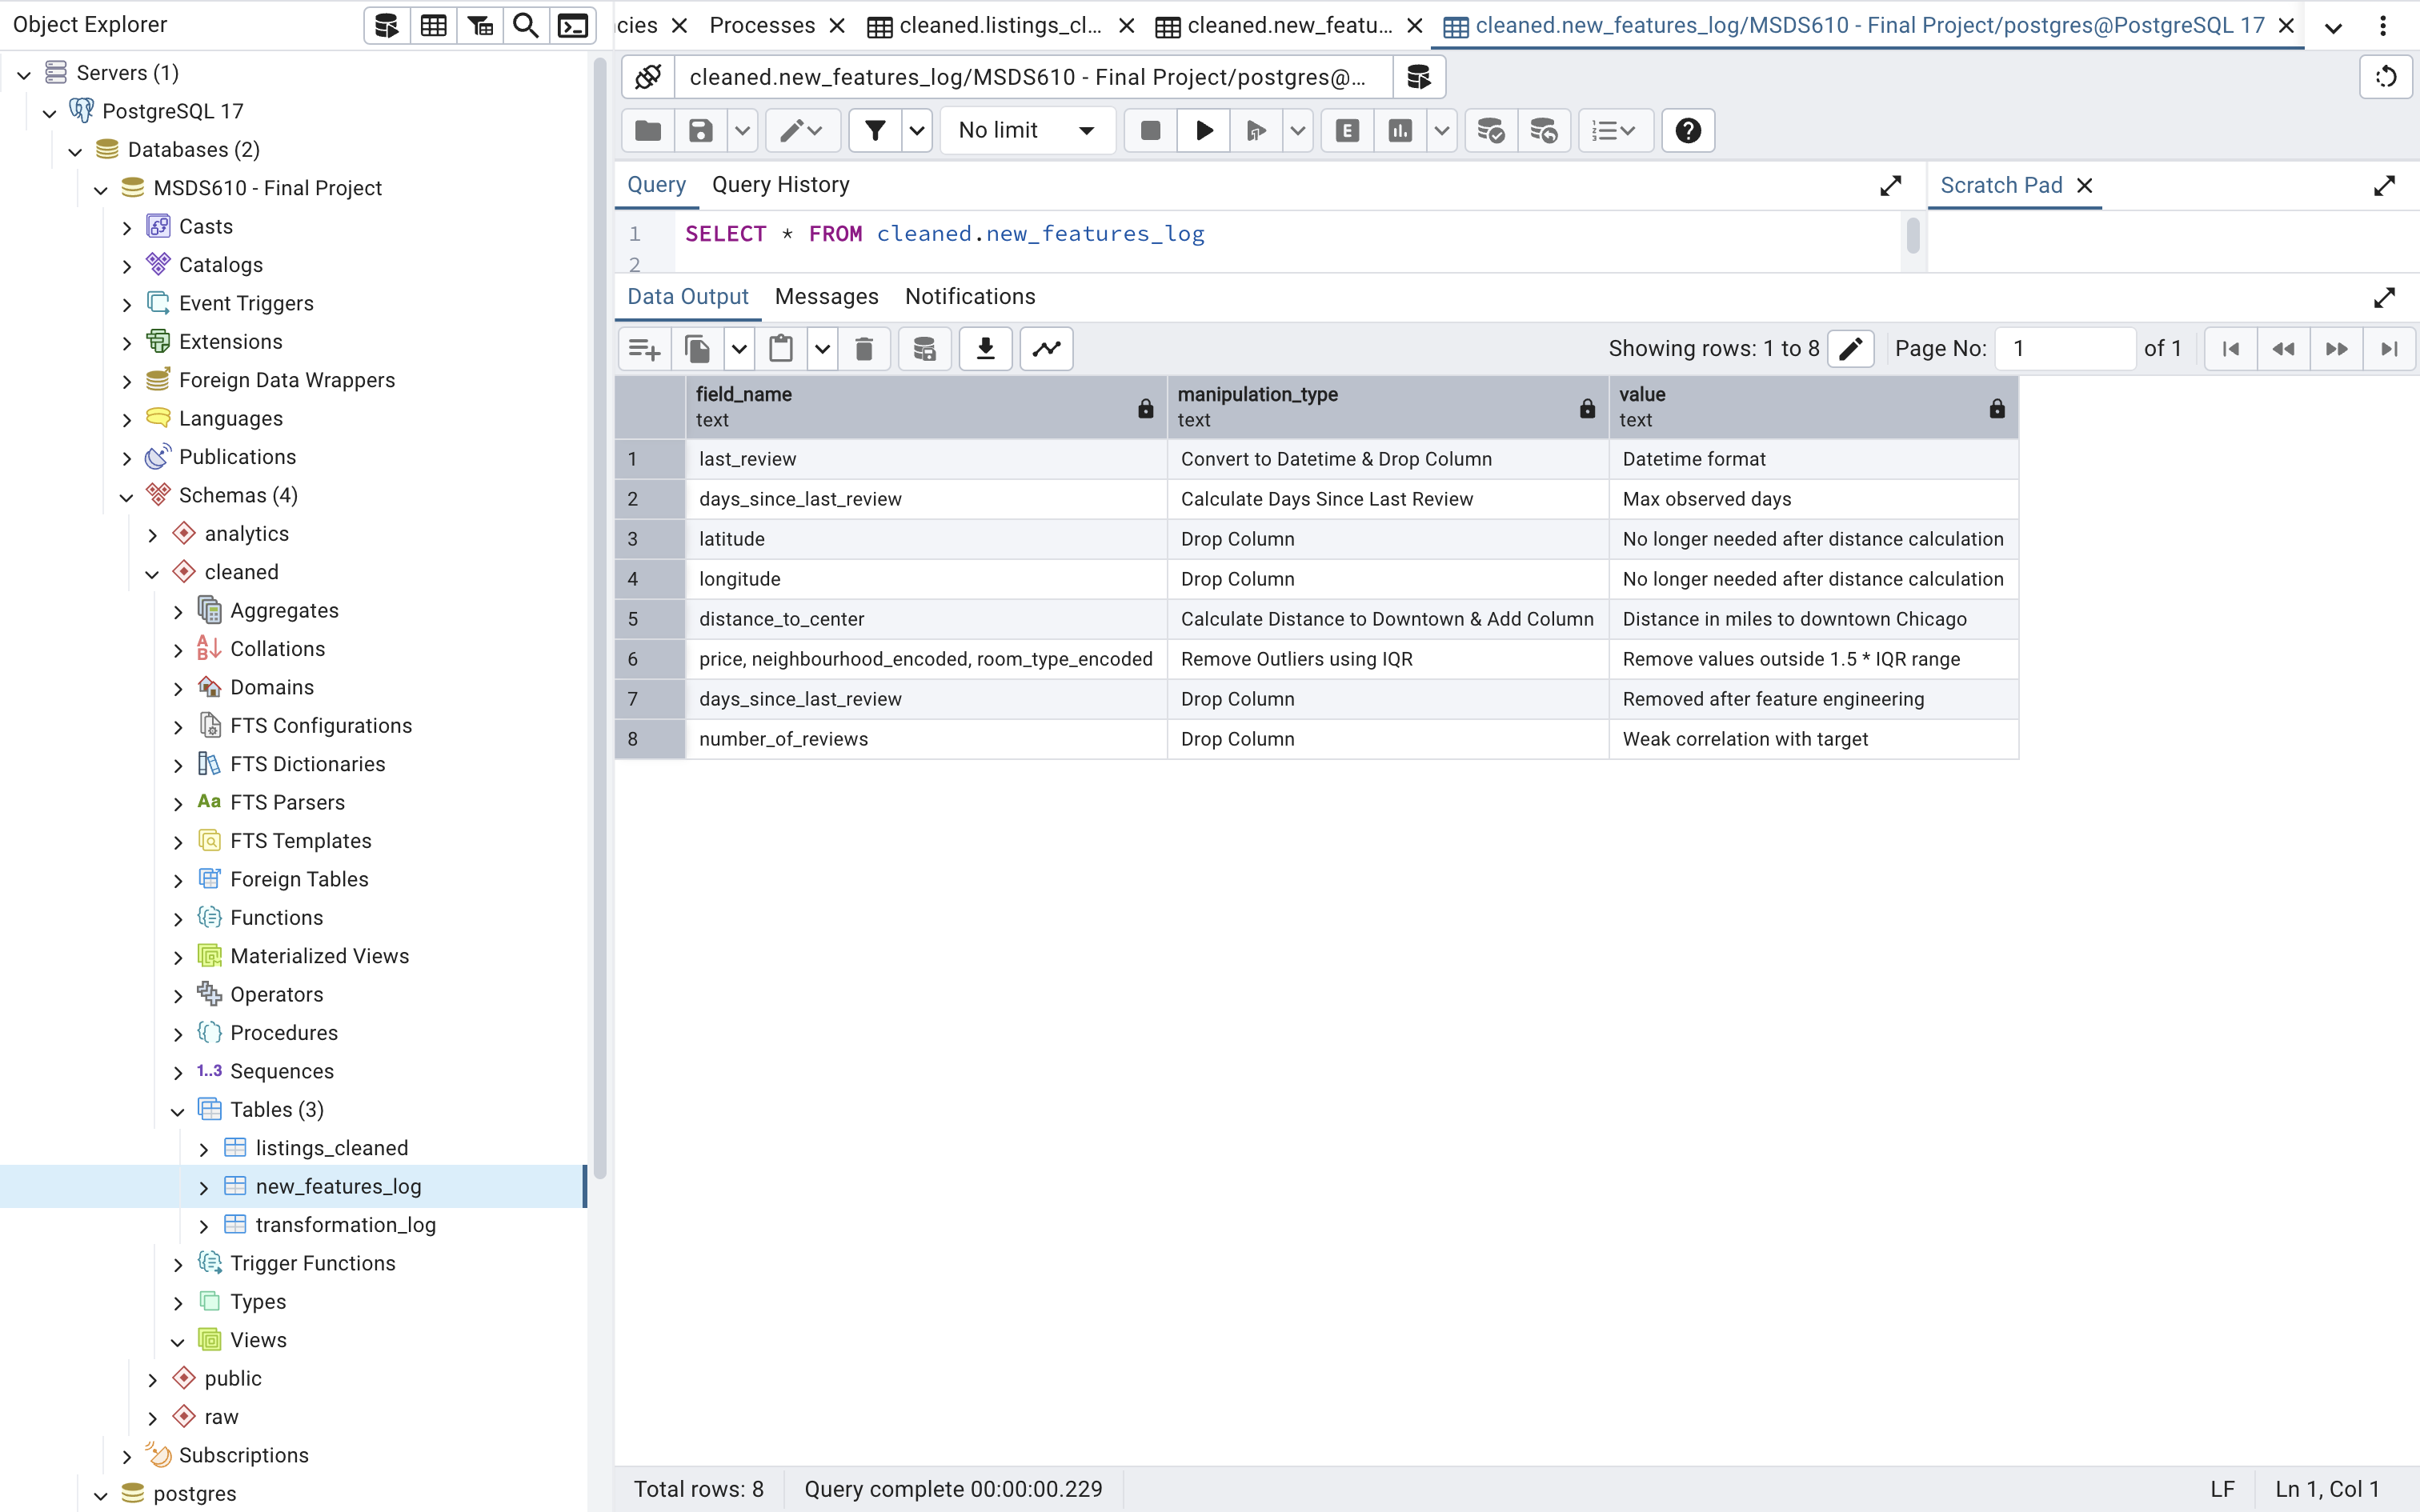

In [1881]:
Image("new_features_log.png")

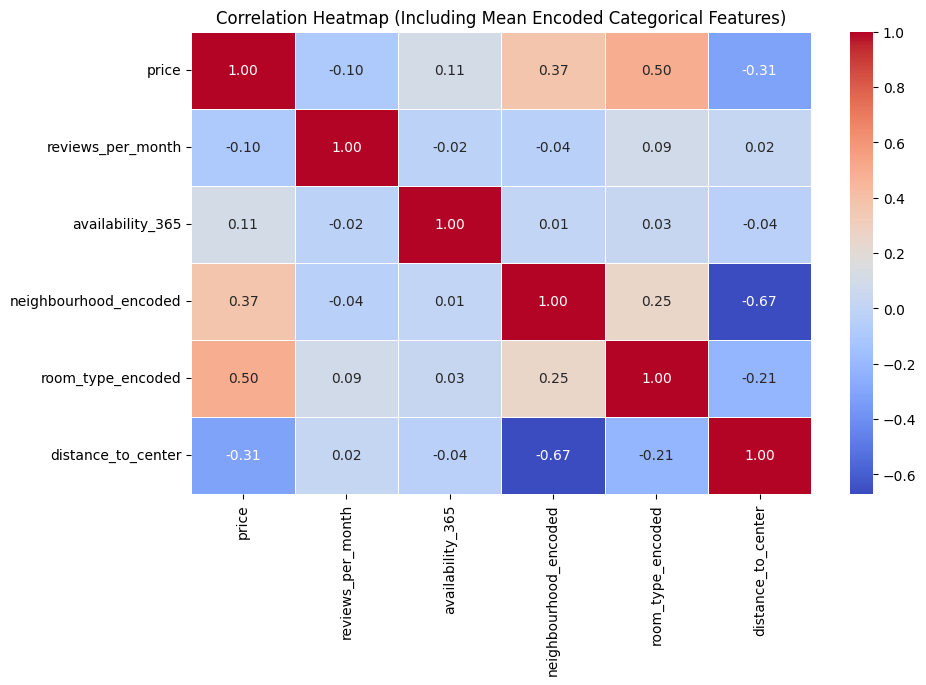

In [1875]:
numeric_columns = listings.select_dtypes(include=['number']).columns
corr_matrix = listings[numeric_columns].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Including Mean Encoded Categorical Features)")
plt.show()

## Part VI : Constructing The Optimal Model

I prepared the data by separating the feature columns and the target column 'price'. Then I split the dataset into three parts: 70% for training, 15% for testing, and 15% for validation. This allowed me to train my model on the training data, evaluate its performance on the test set, and fine-tune it using the validation set. 

In [1876]:
cols = listings.columns
prediction_col = 'price'
feature_cols = [c for c in cols if c != prediction_col]
X = listings[feature_cols]
y = listings[prediction_col]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, random_state=42, test_size=0.5)

 I chose Linear Regression because the target variable, price, is continuous, not a class. It's also simple and interpretable. The results show that the model's accuracy is 33% across training, test, and validation. This shows the model performs decently but not very effectively, and that is generalizes well and does not overfit.

In [1877]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Training R^2: {train_r2:.4f}, MSE: {train_mse:.4f}")
print(f"Validation R^2: {val_r2:.4f}, MSE: {val_mse:.4f}")
print(f"Test R^2: {test_r2:.4f}, MSE: {test_mse:.4f}")

Training R^2: 0.3334, MSE: 2222.4080
Validation R^2: 0.3445, MSE: 2221.9145
Test R^2: 0.3548, MSE: 2079.6218


In [1878]:
model_filename = "airbnb_model.joblib"
joblib.dump(model, model_filename)

['airbnb_model.joblib']

In [1879]:
pd.DataFrame(X_val).to_csv("X_val.csv", index=False)
pd.DataFrame(y_val).to_csv("y_val.csv", index=False)